## 放在caffe/examples文件夹下 python2.7

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# Make sure that caffe is on the python path:
caffe_root = '../'  # this file is expected to be in {caffe_root}/examples
import sys
sys.path.insert(0, caffe_root + 'python')
import caffe
import os

In [2]:
if os.path.isfile(caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'):
    print 'CaffeNet found.'
else:
    print 'Downloading pre-trained CaffeNet model...'
    !../scripts/download_model_binary.py ../models/bvlc_reference_caffenet

CaffeNet found.


In [14]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
#     padding = (((0, n ** 2 - data.shape[0]),
#                (0, 1), (0, 1))                 # add some space between filters
#                + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
#     data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    plt.imshow(data); plt.axis('off')
    plt.savefig('test.png',frameon=False)

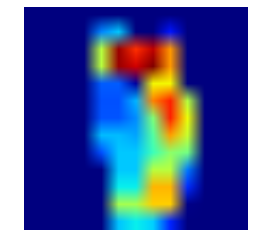

In [15]:
vis_square(feat)

In [4]:
!diff net_surgery/bvlc_caffenet_full_conv.prototxt ../models/bvlc_reference_caffenet/deploy.prototxt

1,2c1
< # Fully convolutional network version of CaffeNet.
< name: "CaffeNetConv"
---
> name: "CaffeNet"
7,11c6
<   input_param {
<     # initial shape for a fully convolutional network:
<     # the shape can be set for each input by reshape.
<     shape: { dim: 1 dim: 3 dim: 451 dim: 451 }
<   }
---
>   input_param { shape: { dim: 10 dim: 3 dim: 227 dim: 227 } }
157,158c152,153
<   name: "fc6-conv"
<   type: "Convolution"
---
>   name: "fc6"
>   type: "InnerProduct"
160,161c155,156
<   top: "fc6-conv"
<   convolution_param {
---
>   top: "fc6"
>   inner_product_param {
163d157
<     kernel_size: 6
169,170c163,164
<   bottom: "fc6-conv"
<   top: "fc6-conv"
---
>   bottom: "fc6"
>   top: "fc6"
175,176c169,170
<   bottom: "fc6-conv"
<   top: "fc6-conv"
---
>   bottom: "fc6"
>   top: "fc6"
182,186c176,180
<   name: "fc7-conv"
<   type: "Convolution"
<   bottom: "fc6-conv"
<   top: "fc7-conv"
<   convolution_param {
---
>   name: "fc7"
>   type: "InnerProduct"
>   bottom: "fc6"
>   top: "f

In [4]:
if os.path.isfile(caffe_root + 'examples/net_surgery/bvlc_caffenet_full_conv.caffemodel'):
    net_full_conv = caffe.Net('net_surgery/bvlc_caffenet_full_conv.prototxt', 
                          'net_surgery/bvlc_caffenet_full_conv.caffemodel',
                          caffe.TEST)
else:
    # Load the original network and extract the fully connected layers' parameters.
    net = caffe.Net('../models/bvlc_reference_caffenet/deploy.prototxt', 
                    '../models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel', 
                    caffe.TEST)
    params = ['fc6', 'fc7', 'fc8']
    # fc_params = {name: (weights, biases)}
    fc_params = {pr: (net.params[pr][0].data, net.params[pr][1].data) for pr in params}
#     for fc in params:
#         print '{} weights are {} dimensional and biases are {} dimensional'.format(fc, fc_params[fc][0].shape, fc_params[fc][1].shape)
    # Load the fully convolutional network to transplant the parameters.
    net_full_conv = caffe.Net('net_surgery/bvlc_caffenet_full_conv.prototxt', 
                              '../models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel',
                              caffe.TEST)
    params_full_conv = ['fc6-conv', 'fc7-conv', 'fc8-conv']
    # conv_params = {name: (weights, biases)}
    conv_params = {pr: (net_full_conv.params[pr][0].data, net_full_conv.params[pr][1].data) for pr in params_full_conv}
#     for conv in params_full_conv:
#         print '{} weights are {} dimensional and biases are {} dimensional'.format(conv, conv_params[conv][0].shape, conv_params[conv][1].shape)
    for pr, pr_conv in zip(params, params_full_conv):
        conv_params[pr_conv][0].flat = fc_params[pr][0].flat  # flat unrolls the arrays
        conv_params[pr_conv][1][...] = fc_params[pr][1]
    net_full_conv.save('net_surgery/bvlc_caffenet_full_conv.caffemodel')

In [9]:
# for each layer, show the output shape
for layer_name, blob in net_full_conv.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

data	(1, 3, 451, 451)
conv1	(1, 96, 111, 111)
pool1	(1, 96, 55, 55)
norm1	(1, 96, 55, 55)
conv2	(1, 256, 55, 55)
pool2	(1, 256, 27, 27)
norm2	(1, 256, 27, 27)
conv3	(1, 384, 27, 27)
conv4	(1, 384, 27, 27)
conv5	(1, 256, 27, 27)
pool5	(1, 256, 13, 13)
fc6-conv	(1, 4096, 8, 8)
fc7-conv	(1, 4096, 8, 8)
fc8-conv	(1, 1000, 8, 8)
prob	(1, 1000, 8, 8)


In [10]:
for layer_name, param in net_full_conv.params.iteritems():
    print layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape)

conv1	(96, 3, 11, 11) (96,)
conv2	(256, 48, 5, 5) (256,)
conv3	(384, 256, 3, 3) (384,)
conv4	(384, 192, 3, 3) (384,)
conv5	(256, 192, 3, 3) (256,)
fc6-conv	(4096, 256, 6, 6) (4096,)
fc7-conv	(4096, 4096, 1, 1) (4096,)
fc8-conv	(1000, 4096, 1, 1) (1000,)


In [71]:
 net_full_conv.blobs['data'].data.shape

(1, 3, 451, 451)

[[282 282 281 281 281 281 277 282]
 [281 283 283 281 281 281 281 282]
 [283 283 283 283 283 283 287 282]
 [283 283 283 281 283 283 283 259]
 [283 283 283 283 283 283 283 259]
 [283 283 283 283 283 283 259 259]
 [283 283 283 283 259 259 259 277]
 [335 335 283 259 263 263 263 277]]


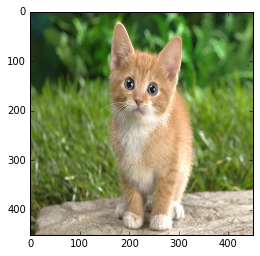

In [5]:
# load input and configure preprocessing
im = caffe.io.load_image('images/cat.jpg')
transformer = caffe.io.Transformer({'data': net_full_conv.blobs['data'].data.shape})
transformer.set_mean('data', np.load('../python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1))
transformer.set_transpose('data', (2,0,1))
transformer.set_channel_swap('data', (2,1,0))
transformer.set_raw_scale('data', 255.0)
# make classification map by forward and print prediction indices at each location
out = net_full_conv.forward_all(data=np.asarray([transformer.preprocess('data', im)]))
print out['prob'][0].argmax(axis=0)
# show net input and confidence map (probability of the top prediction at each location)
# plt.subplot(1, 2, 1)
plt.imshow(transformer.deprocess('data', net_full_conv.blobs['data'].data[0]))
# plt.subplot(1, 2, 2)
# plt.imshow(out['prob'][0,169])

In [6]:
feat = net_full_conv.blobs['pool5'].data[0,5:6]

In [34]:
from PIL import Image

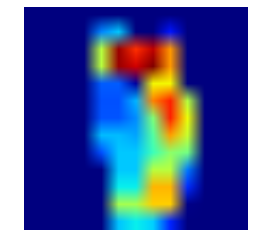

In [11]:
vis_square(feat)

In [31]:
feat.shape,transformer.deprocess('data', net_full_conv.blobs['data'].data[0]).shape

((1, 13, 13), (451, 451, 3))

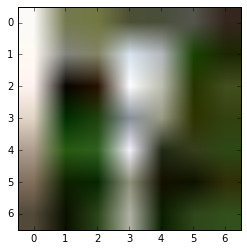

In [37]:
plt.imshow(im1)

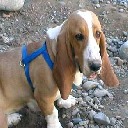

In [32]:
im2.resize((128,128))

In [33]:
Image.blend(im1,im2,0.1) 

ValueError: images do not match

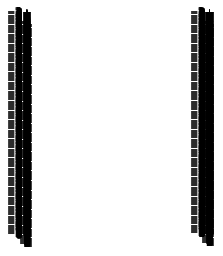

In [21]:
for i in range(1,400):
    plt.subplot(200, 2, i)
    plt.imshow(out['prob'][0,i])

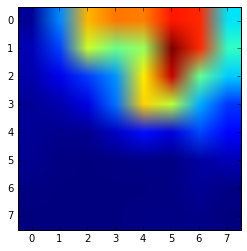

In [14]:
plt.imshow(out['prob'][0,152])

blobs ['data', 'conv']
params ['conv']


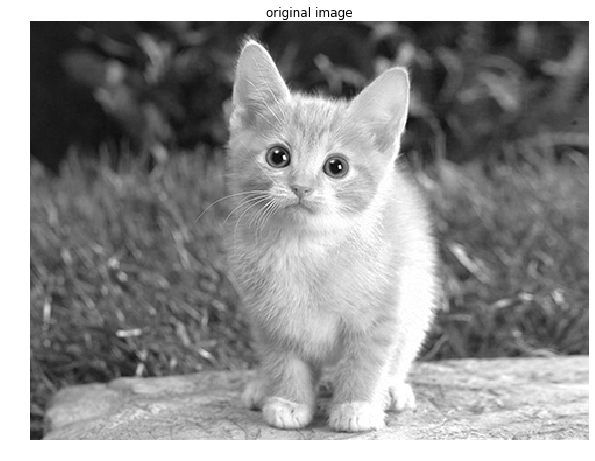

In [2]:
# Load the net, list its data and params, and filter an example image.
caffe.set_mode_cpu()
net = caffe.Net('net_surgery/conv.prototxt', caffe.TEST)
print("blobs {}\nparams {}".format(net.blobs.keys(), net.params.keys()))

# load image and prepare as a single input batch for Caffe
im = np.array(caffe.io.load_image('images/cat_gray.jpg', color=False)).squeeze()
plt.title("original image")
plt.imshow(im)
plt.axis('off')

im_input = im[np.newaxis, np.newaxis, :, :]
net.blobs['data'].reshape(*im_input.shape)
net.blobs['data'].data[...] = im_input

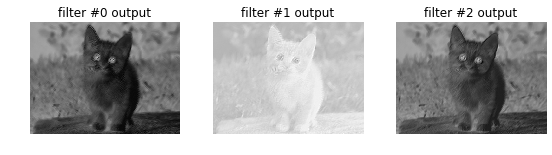

In [3]:
# helper show filter outputs
def show_filters(net):
    net.forward()
    plt.figure()
    filt_min, filt_max = net.blobs['conv'].data.min(), net.blobs['conv'].data.max()
    for i in range(3):
        plt.subplot(1,4,i+2)
        plt.title("filter #{} output".format(i))
        plt.imshow(net.blobs['conv'].data[0, i], vmin=filt_min, vmax=filt_max)
        plt.tight_layout()
        plt.axis('off')

# filter the image with initial 
show_filters(net)

In [4]:
# pick first filter output
conv0 = net.blobs['conv'].data[0, 0]
print("pre-surgery output mean {:.2f}".format(conv0.mean()))
# set first filter bias to 1
net.params['conv'][1].data[0] = 1.
net.forward()
print("post-surgery output mean {:.2f}".format(conv0.mean()))

pre-surgery output mean -0.04
post-surgery output mean 0.96


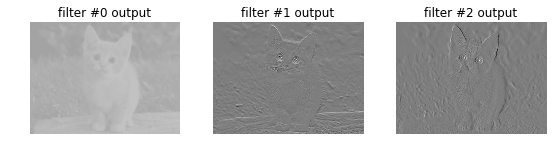

In [5]:
ksize = net.params['conv'][0].data.shape[2:]
# make Gaussian blur
sigma = 1.
y, x = np.mgrid[-ksize[0]//2 + 1:ksize[0]//2 + 1, -ksize[1]//2 + 1:ksize[1]//2 + 1]
g = np.exp(-((x**2 + y**2)/(2.0*sigma**2)))
gaussian = (g / g.sum()).astype(np.float32)
net.params['conv'][0].data[0] = gaussian
# make Sobel operator for edge detection
net.params['conv'][0].data[1:] = 0.
sobel = np.array((-1, -2, -1, 0, 0, 0, 1, 2, 1), dtype=np.float32).reshape((3,3))
net.params['conv'][0].data[1, 0, 1:-1, 1:-1] = sobel  # horizontal
net.params['conv'][0].data[2, 0, 1:-1, 1:-1] = sobel.T  # vertical
show_filters(net)

In [6]:
!diff net_surgery/bvlc_caffenet_full_conv.prototxt ../models/bvlc_reference_caffenet/deploy.prototxt

1,2c1
< # Fully convolutional network version of CaffeNet.
< name: "CaffeNetConv"
---
> name: "CaffeNet"
7,11c6
<   input_param {
<     # initial shape for a fully convolutional network:
<     # the shape can be set for each input by reshape.
<     shape: { dim: 1 dim: 3 dim: 451 dim: 451 }
<   }
---
>   input_param { shape: { dim: 10 dim: 3 dim: 227 dim: 227 } }
157,158c152,153
<   name: "fc6-conv"
<   type: "Convolution"
---
>   name: "fc6"
>   type: "InnerProduct"
160,161c155,156
<   top: "fc6-conv"
<   convolution_param {
---
>   top: "fc6"
>   inner_product_param {
163d157
<     kernel_size: 6
169,170c163,164
<   bottom: "fc6-conv"
<   top: "fc6-conv"
---
>   bottom: "fc6"
>   top: "fc6"
175,176c169,170
<   bottom: "fc6-conv"
<   top: "fc6-conv"
---
>   bottom: "fc6"
>   top: "fc6"
182,186c176,180
<   name: "fc7-conv"
<   type: "Convolution"
<   bottom: "fc6-conv"
<   top: "fc7-conv"
<   convolution_param {
---
>   name: "fc7"
>   type: "InnerProduct"
>   bottom: "fc6"
>   top: "f

In [13]:
# Load the original network and extract the fully connected layers' parameters.
net = caffe.Net('../models/bvlc_reference_caffenet/deploy.prototxt', 
                '../models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel', 
                caffe.TEST)
params = ['fc6', 'fc7', 'fc8']
# fc_params = {name: (weights, biases)}
fc_params = {pr: (net.params[pr][0].data, net.params[pr][1].data) for pr in params}

for fc in params:
    print '{} weights are {} dimensional and biases are {} dimensional'.format(fc, fc_params[fc][0].shape, fc_params[fc][1].shape)

fc6 weights are (4096, 9216) dimensional and biases are (4096,) dimensional
fc7 weights are (4096, 4096) dimensional and biases are (4096,) dimensional
fc8 weights are (1000, 4096) dimensional and biases are (1000,) dimensional


In [10]:
# Load the fully convolutional network to transplant the parameters.
net_full_conv = caffe.Net('net_surgery/bvlc_caffenet_full_conv.prototxt', 
                          '../models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel',
                          caffe.TEST)
params_full_conv = ['fc6-conv', 'fc7-conv', 'fc8-conv']
# conv_params = {name: (weights, biases)}
conv_params = {pr: (net_full_conv.params[pr][0].data, net_full_conv.params[pr][1].data) for pr in params_full_conv}

for conv in params_full_conv:
    print '{} weights are {} dimensional and biases are {} dimensional'.format(conv, conv_params[conv][0].shape, conv_params[conv][1].shape)

fc6-conv weights are (4096, 256, 6, 6) dimensional and biases are (4096,) dimensional
fc7-conv weights are (4096, 4096, 1, 1) dimensional and biases are (4096,) dimensional
fc8-conv weights are (1000, 4096, 1, 1) dimensional and biases are (1000,) dimensional


In [14]:
for pr, pr_conv in zip(params, params_full_conv):
    conv_params[pr_conv][0].flat = fc_params[pr][0].flat  # flat unrolls the arrays
    conv_params[pr_conv][1][...] = fc_params[pr][1]

In [16]:
net_full_conv.save('net_surgery/bvlc_caffenet_full_conv.caffemodel')

[[282 282 281 281 281 281 277 282]
 [281 283 283 281 281 281 281 282]
 [283 283 283 283 283 283 287 282]
 [283 283 283 281 283 283 283 259]
 [283 283 283 283 283 283 283 259]
 [283 283 283 283 283 283 259 259]
 [283 283 283 283 259 259 259 277]
 [335 335 283 259 263 263 263 277]]


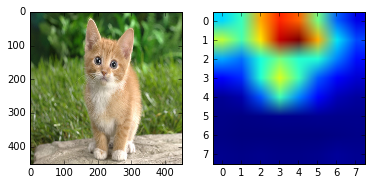

In [15]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# load input and configure preprocessing
im = caffe.io.load_image('images/cat.jpg')
transformer = caffe.io.Transformer({'data': net_full_conv.blobs['data'].data.shape})
transformer.set_mean('data', np.load('../python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1))
transformer.set_transpose('data', (2,0,1))
transformer.set_channel_swap('data', (2,1,0))
transformer.set_raw_scale('data', 255.0)
# make classification map by forward and print prediction indices at each location
out = net_full_conv.forward_all(data=np.asarray([transformer.preprocess('data', im)]))
print out['prob'][0].argmax(axis=0)
# show net input and confidence map (probability of the top prediction at each location)
plt.subplot(1, 2, 1)
plt.imshow(transformer.deprocess('data', net_full_conv.blobs['data'].data[0]))
plt.subplot(1, 2, 2)
plt.imshow(out['prob'][0,281])

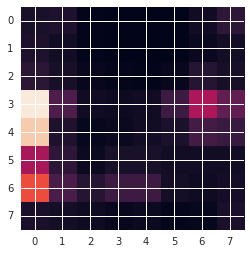

In [53]:
plt.imshow(out['prob'][0,21])

In [26]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()

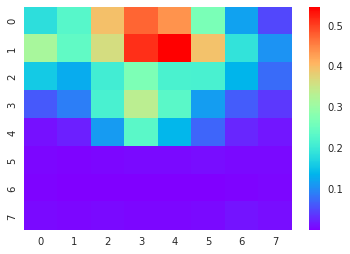

In [50]:
ax = sns.heatmap(out['prob'][0,281], cmap='rainbow')

In [52]:

out['prob'][0,281]

array([[ 0.1869584 ,  0.22995377,  0.39986512,  0.47549573,  0.43968871,
         0.26919407,  0.12110611,  0.05180111],
       [ 0.31810462,  0.24125062,  0.36573383,  0.51481861,  0.54738718,
         0.39803308,  0.19188254,  0.10853015],
       [ 0.16138805,  0.13001263,  0.21052465,  0.27057287,  0.21889266,
         0.21509007,  0.13954586,  0.07749266],
       [ 0.06467591,  0.09124339,  0.21558151,  0.33793652,  0.23572998,
         0.11704788,  0.06775624,  0.04175203],
       [ 0.01387536,  0.02345863,  0.11558309,  0.23504634,  0.14177443,
         0.07343324,  0.02937502,  0.01861678],
       [ 0.00601456,  0.00414455,  0.00783387,  0.00809933,  0.00958278,
         0.01118413,  0.00977855,  0.01000531],
       [ 0.00470169,  0.00223127,  0.0016925 ,  0.00167515,  0.00191617,
         0.00213827,  0.00416473,  0.00687627],
       [ 0.00889342,  0.00720145,  0.00966997,  0.00785047,  0.00649023,
         0.00941425,  0.01600034,  0.01187797]], dtype=float32)

In [31]:
data = []    # download test data    
url="https://raw.github.com/oldj/pyheatmap/master/examples/test_data.txt"
sdata = urllib.urlopen(url).read().split("\n")

NameError: name 'urllib' is not defined

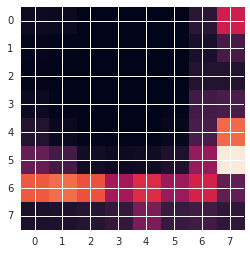

In [55]:
plt.imshow(out['prob'][0,2])

In [19]:
net_full_conv.params

OrderedDict([('conv1', <caffe._caffe.BlobVec at 0x7f14141e0d70>),
             ('conv2', <caffe._caffe.BlobVec at 0x7f14141e0600>),
             ('conv3', <caffe._caffe.BlobVec at 0x7f14141e0520>),
             ('conv4', <caffe._caffe.BlobVec at 0x7f14141e0440>),
             ('conv5', <caffe._caffe.BlobVec at 0x7f14141e03d0>),
             ('fc6-conv', <caffe._caffe.BlobVec at 0x7f14141e0360>),
             ('fc7-conv', <caffe._caffe.BlobVec at 0x7f14141e02f0>),
             ('fc8-conv', <caffe._caffe.BlobVec at 0x7f14141e0280>)])

[-2.98718882  2.99012184 -2.8885622   3.05106282]
[-2.98718882  2.99012184 -2.8885622   3.05106282]
[-2.98718882  2.99012184 -2.8885622   3.05106282]


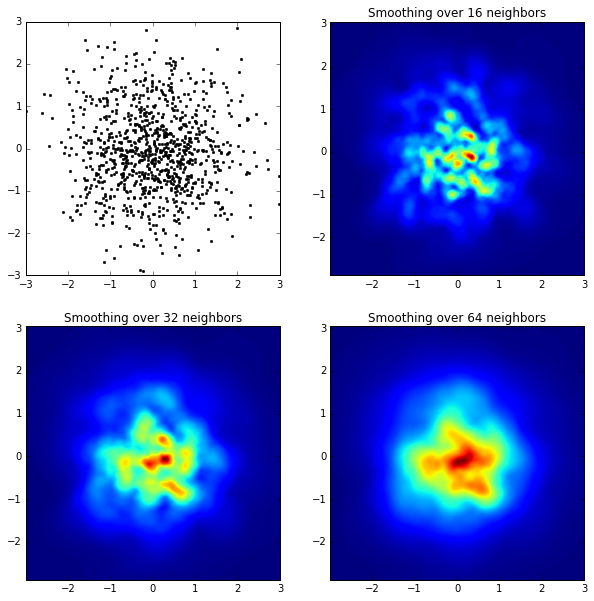

In [2]:
import numpy as np
import numpy.random
import matplotlib.pyplot as plt
import sphviewer as sph

def myplot(x, y, nb=32, xsize=500, ysize=500):   
    xmin = np.min(x)
    xmax = np.max(x)
    ymin = np.min(y)
    ymax = np.max(y)

    x0 = (xmin+xmax)/2.
    y0 = (ymin+ymax)/2.

    pos = np.zeros([3, len(x)])
    pos[0,:] = x
    pos[1,:] = y
    w = np.ones(len(x))

    P = sph.Particles(pos, w, nb=nb)
    S = sph.Scene(P)
    S.update_camera(r='infinity', x=x0, y=y0, z=0, 
                    xsize=xsize, ysize=ysize)
    R = sph.Render(S)
    R.set_logscale()
    img = R.get_image()
    extent = R.get_extent()
    for i, j in zip(xrange(4), [x0,x0,y0,y0]):
        extent[i] += j
    print extent
    return img, extent

fig = plt.figure(1, figsize=(10,10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)


# Generate some test data
x = np.random.randn(1000)
y = np.random.randn(1000)

#Plotting a regular scatter plot
ax1.plot(x,y,'k.', markersize=5)
ax1.set_xlim(-3,3)
ax1.set_ylim(-3,3)

heatmap_16, extent_16 = myplot(x,y, nb=16)
heatmap_32, extent_32 = myplot(x,y, nb=32)
heatmap_64, extent_64 = myplot(x,y, nb=64)

ax2.imshow(heatmap_16, extent=extent_16, origin='lower', aspect='auto')
ax2.set_title("Smoothing over 16 neighbors")

ax3.imshow(heatmap_32, extent=extent_32, origin='lower', aspect='auto')
ax3.set_title("Smoothing over 32 neighbors")

#Make the heatmap using a smoothing over 64 neighbors
ax4.imshow(heatmap_64, extent=extent_64, origin='lower', aspect='auto')
ax4.set_title("Smoothing over 64 neighbors")

plt.show()